In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
from pyqg_generative.models.ols_model import OLSModel
from pyqg_generative.models.mean_var_model import MeanVarModel
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.tools.stochastic_pyqg import stochastic_QGModel
from pyqg_generative.tools.spectral_tools import spectrum
from pyqg_generative.tools.comparison_tools import *
import pyqg_parameterization_benchmarks as ppb
import json
%load_ext autoreload
%autoreload 3

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pp2681/pyqg_experiments/pyqg_subgrid_experiments/__init__.py:19: UserWarning: Unable to load differentiable_parameterizations, install autograd if you want to use these
  warnings.warn("Unable to load differentiable_parameterizations, install autograd if you want to use these")


In [9]:
for folder in folder_iterator(return_blowup=True):
    nfiles = len(glob.glob(os.path.join(folder, '*.nc')))
    if nfiles < 10:
        print('Blow up experiment:', folder)
        print(nfiles)

Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/OLSModel/eddy-constant-0
7
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-12
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-24
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-36
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-48
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-constant-0
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-32/MeanVarModel/eddy-AR1-12
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-32/MeanVarModel/eddy-AR1

In [66]:
highres = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/*.nc', combine='nested', concat_dim='run').load()
lowres = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc', combine='nested', concat_dim='run').load()

In [67]:
ds = coarsegrain_reference_dataset(highres, 64, 'Operator1')

var =  q
var =  u
var =  v
var =  psi


In [86]:
model = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-0/*.nc', combine='nested', concat_dim='run')

In [122]:
%time ppb.diagnostic_similarities(model, ds, lowres, T=128)

CPU times: user 1min 10s, sys: 5.16 s, total: 1min 15s
Wall time: 1min 15s


{'distrib_diff_q1': 0.858958848737749,
 'distrib_diff_q2': 0.6829852218793004,
 'distrib_diff_u1': 0.8365561707176606,
 'distrib_diff_u2': 0.8359515205384592,
 'distrib_diff_v1': 0.8239561245227166,
 'distrib_diff_v2': 0.771637605692762,
 'distrib_diff_KE1': 0.8146259291083773,
 'distrib_diff_KE2': 0.7922537680920104,
 'distrib_diff_Ens1': 0.4273043973838644,
 'distrib_diff_Ens2': 0.9046362065639878,
 'spectral_diff_KEspec1': 0.7022520926440158,
 'spectral_diff_KEspec2': 0.7462702366351059,
 'spectral_diff_KEflux': 0.67189171244816,
 'spectral_diff_APEflux': 0.6747191576393875,
 'spectral_diff_APEgenspec': 0.7034482416054892,
 'spectral_diff_KEfrictionspec': 0.7462701065564776}

In [123]:
%time ppb.diagnostic_similarities(model, highres, lowres, T=1)

CPU times: user 4.36 s, sys: 187 ms, total: 4.55 s
Wall time: 4.35 s


{'distrib_diff_q1': 0.4782988103506248,
 'distrib_diff_q2': 0.5478571219381726,
 'distrib_diff_u1': 0.6549958889167478,
 'distrib_diff_u2': 0.5696289673682191,
 'distrib_diff_v1': 0.6647169852138799,
 'distrib_diff_v2': 0.6201911718994578,
 'distrib_diff_KE1': 0.6833885827469166,
 'distrib_diff_KE2': 0.5772909989774108,
 'distrib_diff_Ens1': 0.25183050288287756,
 'distrib_diff_Ens2': 0.615745445766283,
 'spectral_diff_KEspec1': 0.7022520686893807,
 'spectral_diff_KEspec2': 0.7462702061045448,
 'spectral_diff_KEflux': 0.6718916355424516,
 'spectral_diff_APEflux': 0.6747191837748199,
 'spectral_diff_APEgenspec': 0.7034481553888974,
 'spectral_diff_KEfrictionspec': 0.7462701927170194}

# Coarsegraining relative to all present filters

In [2]:
highres = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/*.nc', combine='nested', concat_dim='run').load()

In [3]:
for resolution in [32, 48, 64, 96]:
    for operator in ['Operator1', 'Operator2']:
        file = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/'+operator+'-'+str(resolution)+'.nc'
        print(file)
        %time coarsegrain_reference_dataset(highres, resolution, operator).to_netcdf(file)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 1min 17s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-32.nc
CPU times: user 1min 17s, sys: 119 ms, total: 1min 17s
Wall time: 1min 17s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
CPU times: user 1min 28s, sys: 591 ms, total: 1min 28s
Wall time: 1min 29s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
CPU times: user 1min 28s, sys: 584 ms, total: 1min 29s
Wall time: 1min 29s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
CPU times: user 1min 34s, sys: 916 ms, total: 1min 35s
Wall time: 1min 36s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
CPU times: user 1min 34s, sys: 930 ms, total: 1min 35s
Wall time: 1min 36s


In [2]:
similarity = {}
for model_folder, reference_folder, baseline_folder, key in folder_iterator(return_reference=True):
    model = xr.open_mfdataset(os.path.join(model_folder, '*.nc'), combine='nested', concat_dim='run').load()
    reference = xr.open_dataset(reference_folder).load()
    baseline = xr.open_mfdataset(baseline_folder, combine='nested', concat_dim='run').load()
    print(model_folder, reference_folder, baseline_folder, key, sep='\n')
    %time similarity[key] = ppb.diagnostic_similarities(model, reference, baseline, T=128)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator1-48/OLSModel/eddy-constant-0
CPU times: user 39.6 s, sys: 2.2 s, total: 41.8 s
Wall time: 41.9 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator1-48/OLSModel/eddy-constant-12
CPU times: user 39.2 s, sys: 2.29 s, total: 41.5 s
Wall time: 41.6 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-

CPU times: user 39.6 s, sys: 1.11 s, total: 40.7 s
Wall time: 40.8 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator2-48/OLSModel/eddy-constant-36
CPU times: user 39.7 s, sys: 546 ms, total: 40.3 s
Wall time: 40.4 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/eddy-constant-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator2-48/OLSModel/eddy-constant-48
CPU times: user 40 s, sys: 1.28 s, total: 41.3 s
Wall time: 41.5 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/MeanVarModel/eddy-AR1-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/ref

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator1-64/OLSModel/eddy-constant-12
CPU times: user 1min 19s, sys: 3.25 s, total: 1min 22s
Wall time: 1min 23s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator1-64/OLSModel/eddy-constant-24
CPU times: user 1min 17s, sys: 2.09 s, total: 1min 19s
Wall time: 1min 20s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_genera

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator1-64/CGANRegression/eddy-constant-48
CPU times: user 1min 14s, sys: 3.04 s, total: 1min 17s
Wall time: 1min 17s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/OLSModel/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator2-64/OLSModel/eddy-constant-0
CPU times: user 1min 13s, sys: 4.29 s, total: 1min 17s
Wall time: 1min 18s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/p

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator2-64/CGANRegression/eddy-constant-24
CPU times: user 1min 9s, sys: 4.37 s, total: 1min 13s
Wall time: 1min 14s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator2-64/CGANRegression/eddy-constant-36
CPU times: user 1min 10s, sys: 2.03 s, total: 1min 12s
Wall time: 1min 12s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/eddy-constant-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.n

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/*.nc
Operator2-96/OLSModel/eddy-constant-12
CPU times: user 3min 2s, sys: 10.3 s, total: 3min 12s
Wall time: 3min 13s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/*.nc
Operator2-96/OLSModel/eddy-constant-24
CPU times: user 3min 2s, sys: 10.6 s, total: 3min 13s
Wall time: 3min 14s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
/scratch/pp2681/pyqg_generati

In [5]:
#with open('similarity.json', 'w') as file:
#    json.dump(similarity, file)

In [3]:
difference = {}
for model_folder, reference_folder, baseline_folder, key in folder_iterator(return_reference=True):
    model = xr.open_mfdataset(os.path.join(model_folder, '*.nc'), combine='nested', concat_dim='run').load()
    reference = xr.open_dataset(reference_folder).load()
    #baseline = xr.open_mfdataset(baseline_folder, combine='nested', concat_dim='run').load()
    print(model_folder, reference_folder, key, sep='\n')
    %time difference[key],_,_ = ppb.diagnostic_differences_Perezhogin(model, reference, T=128)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-AR1-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
Operator1-32/MeanVarModel/eddy-AR1-12
CPU times: user 7.92 s, sys: 493 ms, total: 8.41 s
Wall time: 8.45 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-AR1-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
Operator1-32/MeanVarModel/eddy-AR1-24
CPU times: user 7.97 s, sys: 207 ms, total: 8.18 s
Wall time: 8.23 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-AR1-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
Operator1-32/MeanVarModel/eddy-AR1-36
CPU times: user 8.07 s, sys: 41.6 ms, total: 8.12 s
Wall time: 8.16 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-A

KeyboardInterrupt: 

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-AR1-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Operator1-48/CGANRegression/eddy-AR1-36
CPU times: user 20.1 s, sys: 1.1 s, total: 21.2 s
Wall time: 21.4 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-AR1-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Operator1-48/CGANRegression/eddy-AR1-48
CPU times: user 20.1 s, sys: 884 ms, total: 21 s
Wall time: 21.1 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Operator1-48/CGANRegression/eddy-constant-0
CPU times: user 20.3 s, sys: 378 ms, total: 20.7 s
Wall time: 20.8 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLS

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-AR1-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
Operator2-64/MeanVarModel/eddy-AR1-24
CPU times: user 37.4 s, sys: 2.19 s, total: 39.6 s
Wall time: 39.9 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-AR1-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
Operator2-64/MeanVarModel/eddy-AR1-36
CPU times: user 38.2 s, sys: 2.13 s, total: 40.4 s
Wall time: 40.6 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-AR1-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
Operator2-64/MeanVarModel/eddy-AR1-48
CPU times: user 37.3 s, sys: 2.24 s, total: 39.6 s
Wall time: 39.8 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-co

CPU times: user 1min 30s, sys: 6.17 s, total: 1min 37s
Wall time: 1min 37s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
Operator2-96/CGANRegression/eddy-constant-0
CPU times: user 1min 31s, sys: 5.97 s, total: 1min 36s
Wall time: 1min 37s


In [14]:
difference = {}
for nfile in range(1,136):
    with open(f'difference/{nfile}.json', 'r') as file:
        d = json.load(file)
        key = d.pop('key')
        difference[key] = d

In [15]:
#with open('difference.json', 'w') as file:
#    json.dump(difference, file)

# Find best time sampling for each model

In [11]:
with open('similarity.json', 'r') as file:
    similarity = json.load(file)
with open('difference.json', 'r') as file:
    difference = json.load(file)

In [15]:
score_for_model(similarity, spectral_score, 64, 'Operator2', 'OLSModel')

{'Operator2-64/OLSModel/eddy-constant-0': -0.27476220370502813}

In [21]:
distrib_score(similarity['Operator2-64/OLSModel/eddy-constant-0'])

-1.3940893462392714

In [27]:
distrib_score(difference['Operator1-96/OLSModel/eddy-constant-0'])

0.0058487925495926485

In [19]:
distrib_score(difference['Operator2-64/Reference'])

0.056271641380205996

In [28]:
hires = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc')

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/5b302d395d2e6e63.cache_netcdf


In [29]:
target = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc')
lores = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/[0-9].nc')
mse = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-0/*.nc')
gz = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/MeanVarModel/eddy-constant-0/*.nc')
gan = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-0/*.nc')
gan12 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-AR1-12/*.nc')

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/4f70657261746f72312d36342e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/MeanVarModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-AR1-12/2a2e6e63.cache_netcdf


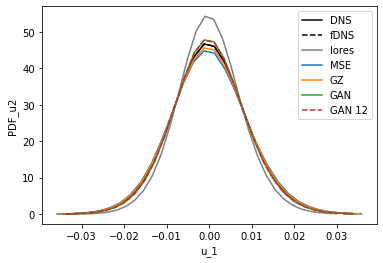

In [30]:
var = 'PDF_u2'
hires[var].plot(label='DNS', ls='-', color='k')
target[var].plot(label='fDNS', ls='--', color='k')
lores[var].plot(label='lores', color='gray')
mse[var].plot(label='MSE')
gz[var].plot(label='GZ', yscale='linear')
gan[var].plot(label='GAN', yscale='linear', xscale='linear')
gan12[var].plot(label='GAN 12', ls='--')
plt.legend()

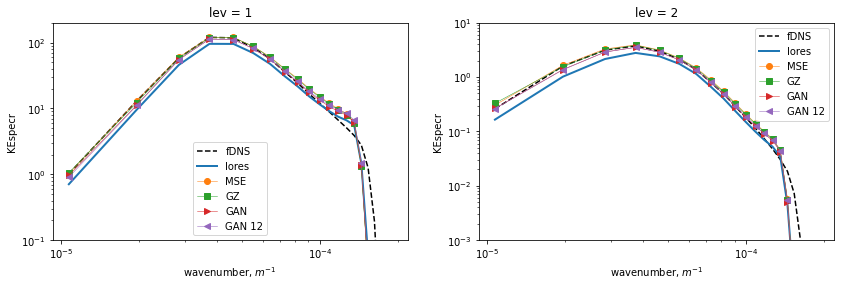

In [31]:
plt.figure(figsize=(14,4))
for lev in [0,1]:
    plt.subplot(1,2,lev+1)
    target.KEspecr.isel(lev=lev).plot(ls='--', color='k', label='fDNS')
    lores.KEspecr.isel(lev=lev).plot(lw=2, label='lores')
    mse.KEspecr.isel(lev=lev).plot(lw=0.5,marker='o', label='MSE')
    gz.KEspecr.isel(lev=lev).plot(lw=0.5,marker='s', label='GZ')
    gan.KEspecr.isel(lev=lev).plot(lw=0.5, label='GAN', marker='>', yscale='log', xscale='log')
    gan12.KEspecr.isel(lev=lev).plot(lw=0.5, label='GAN 12', marker='<', yscale='log', xscale='log')
    if lev==0:
        plt.ylim([1e-1, 2e+2])
    else:
        plt.ylim([1e-3, 1e+1])
    plt.legend()

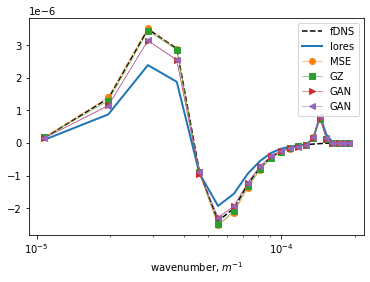

In [32]:
target.KEfluxr.plot(ls='--', color='k', label='fDNS')
lores.KEfluxr.plot(lw=2, label='lores')
(mse.KEfluxr+mse.paramspec_KEfluxr).plot(lw=0.5,marker='o', label='MSE')
(gz.KEfluxr+gz.paramspec_KEfluxr).plot(lw=0.5,marker='s', label='GZ')
(gan.KEfluxr+gan.paramspec_KEfluxr).plot(lw=0.5, label='GAN', marker='>', xscale='log')
(gan12.KEfluxr+gan12.paramspec_KEfluxr).plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

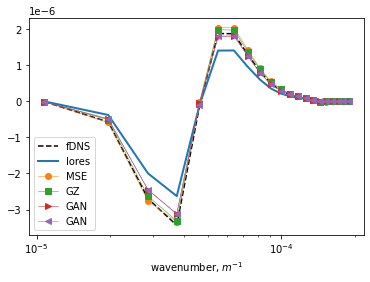

In [33]:
target.APEfluxr.plot(ls='--', color='k', label='fDNS')
lores.APEfluxr.plot(lw=2, label='lores')
(mse.APEfluxr+mse.paramspec_APEfluxr).plot(lw=0.5,marker='o', label='MSE')
(gz.APEfluxr+gz.paramspec_APEfluxr).plot(lw=0.5,marker='s', label='GZ')
(gan.APEfluxr+gan.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='>', xscale='log')
(gan12.APEfluxr+gan12.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

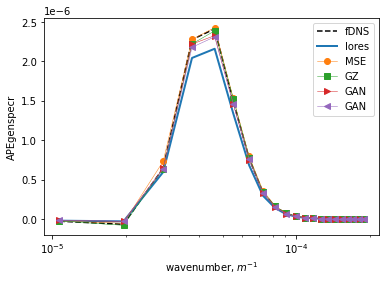

In [34]:
target.APEgenspecr.plot(ls='--', color='k', label='fDNS')
lores.APEgenspecr.plot(lw=2, label='lores')
mse.APEgenspecr.plot(lw=0.5,marker='o', label='MSE')
gz.APEgenspecr.plot(lw=0.5,marker='s', label='GZ')
gan.APEgenspecr.plot(lw=0.5, label='GAN', marker='>', xscale='log')
gan12.APEgenspecr.plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

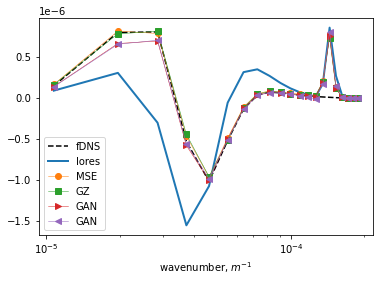

In [35]:
(target.KEfluxr+target.APEfluxr).plot(ls='--', color='k', label='fDNS')
(lores.KEfluxr+target.APEfluxr).plot(lw=2, label='lores')
(mse.KEfluxr+mse.paramspec_KEfluxr+mse.APEfluxr+mse.paramspec_APEfluxr).plot(lw=0.5,marker='o', label='MSE')
(gz.KEfluxr+gz.paramspec_KEfluxr+gz.APEfluxr+gz.paramspec_APEfluxr).plot(lw=0.5,marker='s', label='GZ')
(gan.KEfluxr+gan.paramspec_KEfluxr+gan.APEfluxr+gan.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='>', xscale='log')
(gan12.KEfluxr+gan.paramspec_KEfluxr+gan12.APEfluxr+gan.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

# New energy decomposition

In [37]:
def read_ds(path):
    ds = pse.Dataset(path)
    w = ds.relative_vorticity.compute()
    PV_advection = ds.advect(ds.u, ds.v, ds.q).compute()
    RV_advection = ds.advect(ds.u, ds.v, w).compute()
    PV_advection_to_RV = ds.PV_to_relative_vorticity(PV_advection).compute()
    E_flux = op.ave_lev(spectrum(type='cospectrum',averaging=True)(ds.psi, PV_advection),delta=0.25)
    KE_flux = op.ave_lev(spectrum(type='cospectrum',averaging=True)(ds.psi, RV_advection),delta=0.25)
    APE_flux = E_flux - KE_flux
    KE_contribution = op.ave_lev(spectrum(type='cospectrum',averaging=True)(ds.psi, PV_advection_to_RV),delta=0.25)
    APE_contribution = E_flux - KE_contribution
    return dict(E_flux=E_flux, KE_flux=KE_flux, APE_flux=APE_flux, KE_contribution=KE_contribution, APE_contribution=APE_contribution)

In [38]:
hires = read_ds('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/0.nc')

In [39]:
lores = read_ds('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc')

(1e-05, 0.0002)

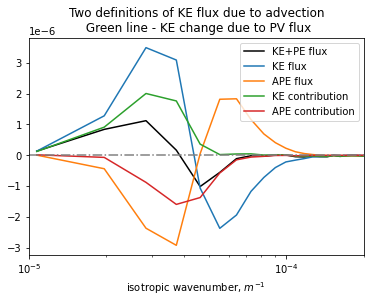

In [40]:
hires['E_flux'].plot(label='KE+PE flux', color='k')
hires['KE_flux'].plot(label='KE flux')
hires['APE_flux'].plot(label='APE flux')
hires['KE_contribution'].plot(label='KE contribution')
hires['APE_contribution'].plot(label='APE contribution', xscale='log')

plt.legend()
plt.title('Two definitions of KE flux due to advection\n Green line - KE change due to PV flux')
plt.axhline(y=0, ls='-.', color='gray')
plt.xlim([1e-5, 2e-4])

(1e-05, 0.0002)

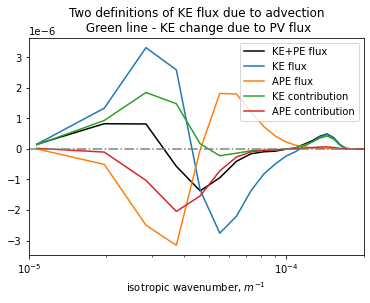

In [41]:
lores['E_flux'].plot(label='KE+PE flux', color='k')
lores['KE_flux'].plot(label='KE flux')
lores['APE_flux'].plot(label='APE flux')
lores['KE_contribution'].plot(label='KE contribution')
lores['APE_contribution'].plot(label='APE contribution', xscale='log')

plt.legend()
plt.title('Two definitions of KE flux due to advection\n Green line - KE change due to PV flux')
plt.axhline(y=0, ls='-.', color='gray')
plt.xlim([1e-5, 2e-4])

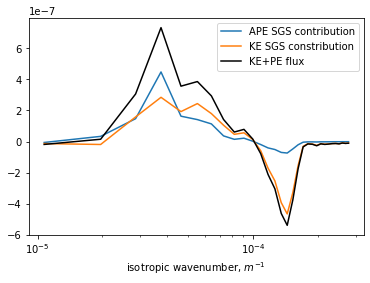

In [53]:
(hires['APE_contribution'] - lores['APE_contribution']).plot(xscale='log', label='APE SGS contribution')
(hires['KE_contribution'] - lores['KE_contribution']).plot(xscale='log', label='KE SGS constribution')
(hires['E_flux'] - lores['E_flux']).plot(label='KE+PE flux', color='k')
plt.legend()

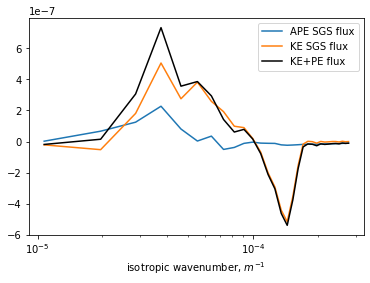

In [55]:
(hires['APE_flux'] - lores['APE_flux']).plot(xscale='log', label='APE SGS flux')
(hires['KE_flux'] - lores['KE_flux']).plot(xscale='log', label='KE SGS flux')
(hires['E_flux'] - lores['E_flux']).plot(label='KE+PE flux', color='k')
plt.legend()

# Ensemble forecasing metrics

In [2]:
operator = 'Operator1'
res = 48
dns = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run')
lores = xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/Reference/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run')

In [17]:
for operator, op_name in zip([op.Operator1, op.Operator2], ['Operator1', 'Operator2']):
    for res in [48, 64, 96]:
        fdns = xr.Dataset()
        for var in ['q', 'u', 'v', 'psi']:
            %time fdns[var] = operator(dns[var], res)
        fdns.to_netcdf(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{op_name}-{str(res)}.nc')

CPU times: user 43.6 s, sys: 24.2 s, total: 1min 7s
Wall time: 1min 7s
CPU times: user 43 s, sys: 22.5 s, total: 1min 5s
Wall time: 1min 7s
CPU times: user 43.1 s, sys: 21.3 s, total: 1min 4s
Wall time: 1min 7s
CPU times: user 43.4 s, sys: 23.4 s, total: 1min 6s
Wall time: 1min 9s
CPU times: user 44.5 s, sys: 21.4 s, total: 1min 5s
Wall time: 1min 5s
CPU times: user 44.7 s, sys: 23.4 s, total: 1min 8s
Wall time: 1min 8s
CPU times: user 44.4 s, sys: 21.8 s, total: 1min 6s
Wall time: 1min 6s
CPU times: user 44.1 s, sys: 20 s, total: 1min 4s
Wall time: 1min 4s
CPU times: user 51.3 s, sys: 24.8 s, total: 1min 16s
Wall time: 1min 16s
CPU times: user 50.4 s, sys: 20.7 s, total: 1min 11s
Wall time: 1min 11s
CPU times: user 51.1 s, sys: 25.2 s, total: 1min 16s
Wall time: 1min 16s
CPU times: user 49.7 s, sys: 21.8 s, total: 1min 11s
Wall time: 1min 11s
CPU times: user 42.8 s, sys: 19.8 s, total: 1min 2s
Wall time: 1min 2s
CPU times: user 43.5 s, sys: 23.6 s, total: 1min 7s
Wall time: 1min 7s
CP

# Precompute spread and shape

In [454]:
gan = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/CGANRegression/eddy-forecast/AR1-48/*.nc',
                     f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')
gz = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/MeanVarModel/eddy-forecast/AR1-48/*.nc',
                     f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')

(1e-06, 200.0)

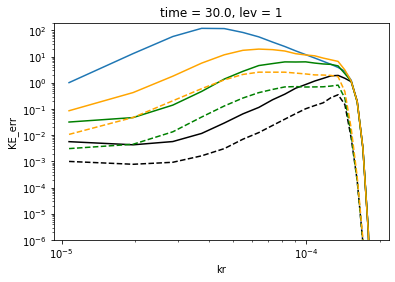

In [455]:
target = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc')
sp = spectrum(averaging=True, truncate=True)
(sp(target.u) + sp(target.v)).isel(lev=0).plot(xscale='log', yscale='log')
gan.KE_res.isel(time=5,lev=0).plot(ls = '--', color='k')
gan.KE_err.isel(time=5,lev=0).plot(color='k')
gan.KE_res.isel(time=15,lev=0).plot(ls = '--', color='g')
gan.KE_err.isel(time=15,lev=0).plot(color='g')
gan.KE_res.isel(time=30,lev=0).plot(ls = '--', color='orange')
gan.KE_err.isel(time=30,lev=0).plot(color='orange')
plt.ylim([1e-6, 2e+2])

(1e-06, 200.0)

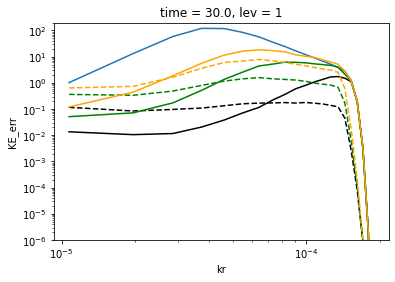

In [456]:
(sp(target.u) + sp(target.v)).isel(lev=0).plot(xscale='log', yscale='log')
gz.KE_res.isel(time=5,lev=0).plot(ls = '--', color='k')
gz.KE_err.isel(time=5,lev=0).plot(color='k')
gz.KE_res.isel(time=15,lev=0).plot(ls = '--', color='g')
gz.KE_err.isel(time=15,lev=0).plot(color='g')
gz.KE_res.isel(time=30,lev=0).plot(ls = '--', color='orange')
gz.KE_err.isel(time=30,lev=0).plot(color='orange')
plt.ylim([1e-6, 2e+2])

In [473]:
for operator in ['Operator1', 'Operator2']:
    for res in [48, 64, 96]:
        for decor in [0, 12, 24, 36, 48]:
            gan = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/CGANRegression/eddy-forecast/AR1-{str(decor)}/*.nc',
                                 f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')
            gz = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/MeanVarModel/eddy-forecast/AR1-{str(decor)}/*.nc',
                                 f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')
            print(operator, res, decor)

Operator1 48 0
Operator1 48 12
Operator1 48 24
Operator1 48 36
Operator1 48 48
Operator1 64 0
Operator1 64 12
Operator1 64 24
Operator1 64 36
Operator1 64 48
Operator1 96 0
Operator1 96 12
Operator1 96 24
Operator1 96 36
Operator1 96 48
Operator2 48 0
Operator2 48 12
Operator2 48 24
Operator2 48 36
Operator2 48 48
Operator2 64 0
Operator2 64 12
Operator2 64 24
Operator2 64 36
Operator2 64 48
Operator2 96 0
Operator2 96 12
Operator2 96 24
Operator2 96 36
Operator2 96 48


In [453]:
operator = 'Operator1'
res = 64
fdns = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc', decode_times=False)
def coords(ds):
    ds['x'] = fdns['x']
    ds['y'] = fdns['y']
    return ds
lores = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/Reference/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run', decode_times=False))
mse = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/OLSModel/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run', decode_times=False))
gz = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/MeanVarModel/eddy-forecast/AR1-48/*.nc', combine='nested', concat_dim='run', decode_times=False))
gan = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/CGANRegression/eddy-forecast/AR1-48/*.nc', combine='nested', concat_dim='run', decode_times=False))

In [4]:
def plot_error(model, target, label, var='q', tmax=None):
    model = model.isel(time=slice(0,tmax))
    target = target.isel(time=slice(0,tmax))
    q_err = (model[var+'_mean'].astype('float64') - target[var].astype('float64'))
    q_spread = (model[var].astype('float64') - model[var+'_mean'].astype('float64'))
    normalize = (target[var].astype('float64')**2).mean(dim=('run', 'x', 'y')).isel(time=0)
    
    err = (q_err**2).mean(dim=('run', 'x', 'y')) / normalize
    spread = (q_spread**2).mean(dim=('run', 'x', 'y')) / normalize
    q_sq = (model[var].astype('float64')**2).mean(dim=('run', 'x', 'y')) / normalize
    q_mean_sq = (model[var+'_mean'].astype('float64')**2).mean(dim=('run', 'x', 'y')) / normalize
    
    plt.subplot(1,3,1)
    line, = err.isel(lev=0).plot(label=label, yscale='linear')
    spread.isel(lev=0).plot(ls='--', color=line._color)
    plt.subplot(1,3,2)
    err.isel(lev=1).plot(label=label, yscale='linear')
    spread.isel(lev=1).plot(ls='--', color=line._color)
    plt.subplot(1,3,3)
    q_sq.isel(lev=1).plot(label=label, yscale='linear')
    q_mean_sq.isel(lev=1).plot(ls='--', color=line._color)

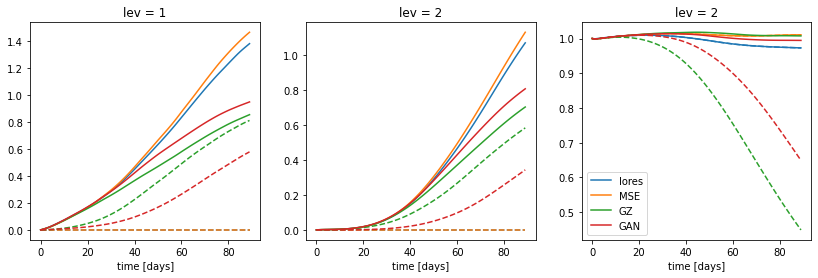

In [5]:
var = 'q'
tmax=90
plt.figure(figsize=(14,4))
plot_error(lores, fdns, 'lores', var, tmax)
plot_error(mse, fdns, 'MSE', var, tmax)
plot_error(gz, fdns, 'GZ', var, tmax)
plot_error(gan, fdns, 'GAN', var, tmax)
plt.legend()

In [4]:
sp = spectrum(averaging=True, truncate=True)

# spectrum of solution

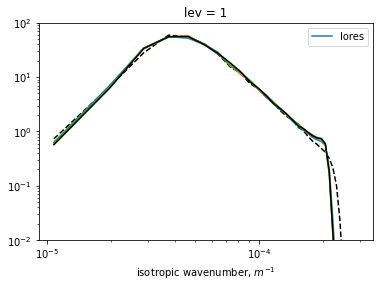

In [22]:
var = 'u'
lev=0
sp(fdns[var].isel(time=0)).isel(lev=lev).plot(color='k', ls='--')
sp(lores[var].isel(time=-1)).isel(lev=lev).plot(label='lores')
sp(mse[var].isel(time=-1)).isel(lev=lev).plot()
sp(gz[var].isel(time=-1)).isel(lev=lev).plot()
sp(gan[var].isel(time=-1)).isel(lev=lev).plot(color='k')
plt.yscale('log')
plt.xscale('log')
if var =='q':
    plt.ylim([1e-8, 1e-5])
elif var=='u' or var=='v':
    plt.ylim([1e-2, 1e+2])
elif var=='psi':
    plt.ylim([1e+7, 1e+12])
plt.legend()

# Spectrum of error and spread

In [2]:
def error(model, target, var, normalize=True):
    er = target[var] - model[var+'_mean']
    if normalize:
        return er / er.std(dim=('x', 'y', 'run'))
    else:
        return er
def spread(model, var, normalize=True):
    er = model[var] - model[var+'_mean']
    if normalize:
        return er / er.std(dim=('x', 'y', 'run'))
    else:
        return er

/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


([<matplotlib.axis.XTick at 0x15440941c3d0>,
 [Text(0, 0, ''), Text(0, 0, '')])

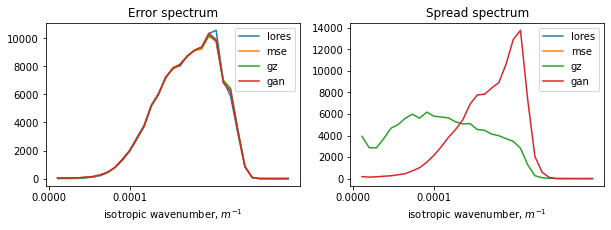

In [25]:
var = 'u'
lev=0
time=5
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
for model, name in zip([lores, mse, gz, gan], ['lores', 'mse', 'gz', 'gan']):
    sp(error(model,fdns,var).isel(time=time)).isel(lev=lev).plot(label=name)
plt.legend()
plt.title('Error spectrum')
plt.xticks([0, 1e-4])
plt.subplot(1,2,2)
for model, name in zip([lores, mse, gz, gan], ['lores', 'mse', 'gz', 'gan']):
    sp(spread(model,var).isel(time=time)).isel(lev=lev).plot(label=name)
plt.legend()
plt.title('Spread spectrum')
plt.xticks([0, 1e-4])

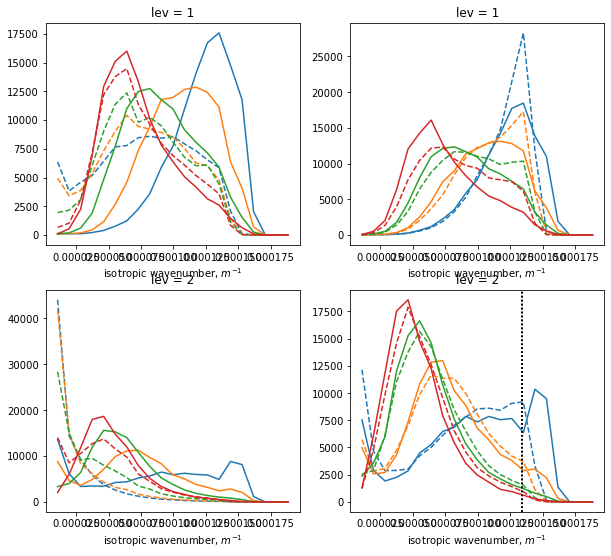

In [18]:
var = 'v'
normalize=True
plt.figure(figsize=(10,9))
for time in [5, 10, 20, 40]:
    
    plt.subplot(2,2,1)
    err = sp(error(gz,fdns,var,normalize).isel(time=time))
    spr = sp(spread(gz,var,normalize).isel(time=time))
    line, = err.isel(lev=0).plot()
    spr.isel(lev=0).plot(ls='--', color=line._color)
    plt.subplot(2,2,3)
    err.isel(lev=1).plot(color=line._color)
    spr.isel(lev=1).plot(ls='--', color=line._color)
    
    plt.subplot(2,2,2)
    err = sp(error(gan,fdns,var,normalize).isel(time=time))
    spr = sp(spread(gan,var,normalize).isel(time=time))
    line, = err.isel(lev=0).plot()
    spr.isel(lev=0).plot(ls='--', color=line._color)
    plt.subplot(2,2,4)
    err.isel(lev=1).plot(color=line._color)
    spr.isel(lev=1).plot(ls='--', color=line._color)
    
    dx = gz.x[2] - gz.x[1]
    kmax = np.pi/dx * 2/3
    plt.axvline(x=kmax, color='k', ls=':')

# Check updated models

In [198]:
import time
base_folder = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models'
for res in [32, 48, 64, 96]:
    for operator in ['Operator1', 'Operator2']:
        model = 'CGANRegression-None-recompute'
        path = base_folder + '/' + operator + '-' + str(res) + '/' + model + '/training.txt'
        os.system(f'cat {path}')
        os.system(f'ls -l {path}')
        os.system(f'echo {operator}, {res}, {model}')
        time.sleep(0.5)
        input()

Namespace(model='CGANRegression', model_args="{'nx': 32, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-32/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator1-32/*.nc')
Training starts on device NVIDIA A100-SXM4-80GB, number of samples 21500
[1/600] [7.18/4301.43] D_loss: -6.01 G_loss: 2.36 L2_mean: [1.012,1.013] L2_total: [0.338,0.342] L2_res: [0.343,0.340]
[2/600] [7.03/4249.42] D_loss: -2.45 G_loss: 5.17 L2_mean: [1.008,1.008] L2_total: [0.650,0.641] L2_res: [0.568,0.560]
[3/600] [6.97/4215.91] D_loss: -1.80 G_loss: 4.12 L2_mean: [0.997,0.999] L2_total: [0.180,0.172] L2_res: [0.202,0.207]
[4/600] [7.16/4223.93] D_loss: -1.64 G_loss: 4.34 L2_mean: [0.993,0.993] L2_total: [0.247,0.261] L2_res: [0.218,0.233]
[5/600] [6.96/4201.98] D_loss: -1.58 G_loss: 5.22 L2_mean: [0.982,0.981] L2_total: [0.234,0.234] L2_res: [0.221,0.218]
[6/600] [6.94/4182.55] D_loss


Namespace(model='CGANRegression', model_args="{'nx': 32, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-32/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator2-32/*.nc')
Training starts on device NVIDIA A100-SXM4-80GB, number of samples 21500
[1/600] [7.23/4328.80] D_loss: -5.47 G_loss: 1.42 L2_mean: [0.996,0.996] L2_total: [0.304,0.311] L2_res: [0.356,0.366]
[2/600] [7.13/4293.10] D_loss: -2.52 G_loss: 4.81 L2_mean: [0.971,0.970] L2_total: [0.401,0.419] L2_res: [0.395,0.410]
[3/600] [7.12/4274.89] D_loss: -1.97 G_loss: 6.28 L2_mean: [0.953,0.953] L2_total: [0.184,0.186] L2_res: [0.243,0.251]
[4/600] [7.00/4243.10] D_loss: -1.77 G_loss: 5.40 L2_mean: [0.943,0.942] L2_total: [0.187,0.192] L2_res: [0.267,0.273]
[5/600] [7.01/4223.04] D_loss: -2.06 G_loss: 4.57 L2_mean: [0.941,0.942] L2_total: [0.130,0.135] L2_res: [0.231,0.233]
[6/600] [7.01/4207.28] D_los


Namespace(model='CGANRegression', model_args="{'nx': 48, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-48/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator1-48/*.nc')
Training starts on device NVIDIA A100-SXM4-80GB, number of samples 21500
[1/600] [10.74/6431.39] D_loss: -10.07 G_loss: 1.55 L2_mean: [1.023,1.023] L2_total: [0.493,0.494] L2_res: [0.432,0.434]
[2/600] [10.74/6421.95] D_loss: -3.67 G_loss: 5.82 L2_mean: [1.014,1.014] L2_total: [0.401,0.397] L2_res: [0.342,0.333]
[3/600] [10.72/6408.16] D_loss: -3.64 G_loss: 5.30 L2_mean: [0.995,0.994] L2_total: [0.225,0.227] L2_res: [0.262,0.259]
[4/600] [10.79/6405.48] D_loss: -2.50 G_loss: 6.17 L2_mean: [0.991,0.991] L2_total: [0.282,0.276] L2_res: [0.240,0.235]
[5/600] [10.51/6366.08] D_loss: -2.63 G_loss: 5.98 L2_mean: [0.981,0.981] L2_total: [0.199,0.194] L2_res: [0.199,0.184]
[6/600] [10.58/6343.59


Namespace(model='CGANRegression', model_args="{'nx': 48, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-48/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator2-48/*.nc')
Training starts on device Quadro RTX 8000, number of samples 21500
[1/600] [35.97/21543.74] D_loss: -11.14 G_loss: 2.90 L2_mean: [0.992,0.991] L2_total: [0.547,0.561] L2_res: [0.407,0.406]
[2/600] [35.78/21452.31] D_loss: -4.13 G_loss: 8.26 L2_mean: [0.962,0.961] L2_total: [0.426,0.429] L2_res: [0.457,0.461]
[3/600] [35.81/21403.27] D_loss: -3.37 G_loss: 8.81 L2_mean: [0.945,0.945] L2_total: [0.269,0.267] L2_res: [0.231,0.237]
[4/600] [35.74/21350.79] D_loss: -3.49 G_loss: 7.97 L2_mean: [0.939,0.939] L2_total: [0.301,0.308] L2_res: [0.284,0.291]
[5/600] [36.07/21344.75] D_loss: -3.63 G_loss: 5.99 L2_mean: [0.933,0.934] L2_total: [0.175,0.183] L2_res: [0.240,0.241]
[6/600] [36.06/21327.59


Namespace(model='CGANRegression', model_args="{'nx': 64, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator1-64/*.nc')
Training starts on device Quadro RTX 8000, number of samples 21500
[1/600] [68.13/40807.35] D_loss: -11.97 G_loss: 6.84 L2_mean: [1.029,1.030] L2_total: [0.446,0.454] L2_res: [0.402,0.408]
[2/600] [68.20/40760.45] D_loss: -5.55 G_loss: 10.02 L2_mean: [1.027,1.028] L2_total: [0.379,0.369] L2_res: [0.318,0.311]
[3/600] [68.07/40673.36] D_loss: -5.16 G_loss: 6.85 L2_mean: [1.008,1.010] L2_total: [0.274,0.276] L2_res: [0.333,0.335]
[4/600] [68.06/40594.52] D_loss: -4.58 G_loss: 8.38 L2_mean: [1.004,1.005] L2_total: [0.216,0.215] L2_res: [0.224,0.223]
[5/600] [67.90/40500.81] D_loss: -4.51 G_loss: 6.71 L2_mean: [0.983,0.982] L2_total: [0.252,0.254] L2_res: [0.281,0.278]
[6/600] [68.04/40429.9


Namespace(model='CGANRegression', model_args="{'nx': 64, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-64/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator2-64/*.nc')
Training starts on device Quadro RTX 8000, number of samples 21500
[1/600] [68.63/41108.36] D_loss: -11.72 G_loss: 4.03 L2_mean: [0.963,0.963] L2_total: [0.362,0.371] L2_res: [0.438,0.445]
[2/600] [68.80/41090.29] D_loss: -5.62 G_loss: 7.69 L2_mean: [0.951,0.951] L2_total: [0.264,0.252] L2_res: [0.183,0.196]
[3/600] [68.66/41010.73] D_loss: -4.91 G_loss: 10.92 L2_mean: [0.925,0.924] L2_total: [0.253,0.241] L2_res: [0.337,0.320]
[4/600] [5328.76/824691.11] D_loss: -6.60 G_loss: 10.87 L2_mean: [0.893,0.893] L2_total: [0.065,0.064] L2_res: [0.211,0.190]
[5/600] [3031.39/1019380.95] D_loss: -7.04 G_loss: 8.49 L2_mean: [0.858,0.860] L2_total: [0.088,0.092] L2_res: [0.160,0.158]
[6/600] [68.34


Namespace(model='CGANRegression', model_args="{'nx': 96, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-96/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator1-96/*.nc')
Training starts on device NVIDIA A100-SXM4-80GB, number of samples 21500
[1/600] [83.12/49790.48] D_loss: -24.46 G_loss: 12.42 L2_mean: [1.032,1.032] L2_total: [0.415,0.421] L2_res: [0.409,0.414]
[2/600] [82.88/49636.16] D_loss: -9.21 G_loss: 16.02 L2_mean: [1.029,1.028] L2_total: [0.372,0.373] L2_res: [0.379,0.385]
[3/600] [82.73/49499.21] D_loss: -8.96 G_loss: 14.22 L2_mean: [1.024,1.025] L2_total: [0.310,0.299] L2_res: [0.353,0.341]
[4/600] [82.89/49413.04] D_loss: -11.99 G_loss: 18.07 L2_mean: [1.023,1.023] L2_total: [0.219,0.216] L2_res: [0.235,0.237]
[5/600] [82.79/49315.64] D_loss: -12.71 G_loss: 21.14 L2_mean: [1.024,1.025] L2_total: [0.305,0.297] L2_res: [0.208,0.206]
[6/600] [8


Namespace(model='CGANRegression', model_args="{'nx': 96, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-96/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator2-96/*.nc')
Training starts on device Quadro RTX 8000, number of samples 21500
[1/600] [120.12/71952.88] D_loss: -21.49 G_loss: 11.13 L2_mean: [0.960,0.959] L2_total: [0.382,0.378] L2_res: [0.481,0.476]
[2/600] [118.02/71205.37] D_loss: -10.12 G_loss: 13.51 L2_mean: [0.938,0.939] L2_total: [0.231,0.224] L2_res: [0.356,0.352]
[3/600] [328.41/112743.88] D_loss: -8.77 G_loss: 15.45 L2_mean: [0.914,0.913] L2_total: [0.144,0.144] L2_res: [0.205,0.195]
[4/600] [117.00/101849.92] D_loss: -10.35 G_loss: 9.82 L2_mean: [0.878,0.879] L2_total: [0.170,0.159] L2_res: [0.172,0.179]
[5/600] [117.52/95328.39] D_loss: -12.06 G_loss: 14.20 L2_mean: [0.837,0.837] L2_total: [0.120,0.124] L2_res: [0.206,0.213]
[6/600] [

# Why noise introduce energy for spectral filter and does not for Gaussian for GZ Model?

In [187]:
def res(ds):
    return ds.q_forcing_advection - ds.q_forcing_advection_mean
def q_to_psi(q):
    nx = len(q.x)
    m = pyqg.QGModel(nx=nx)
    m.q = q.values.squeeze().astype('float64')
    m._invert()
    return m.to_dataset().p
def dEdt(ds, sgs, tau=48):
    dqdt_mean = sgs.q_forcing_advection_mean
    dqdt_res = res(sgs)
    E_mean = op.ave_lev(spectrum(type='cospectrum')(-ds.psi.squeeze(), dqdt_mean.squeeze()), 0.25)
    E_sgs = op.ave_lev(tau * (60*60) * spectrum(type='cospectrum')(-q_to_psi(dqdt_res).squeeze(), dqdt_res.squeeze()), 0.25)
    return E_mean, E_sgs, E_mean+E_sgs
def plotter():
    plt.figure(figsize=(12,4))
    for col, zz in enumerate(zip([ds_offline, ds_online], [sgs_offline, sgs_online], ['offline', 'online'])):
        ds, sgs, name = zz
        noise_var = float(sgs.q_forcing_advection_var.isel(lev=0).mean())
        signal_var = float(sgs.q_forcing_advection.isel(lev=0).var())
        print('Noise to signal var:', noise_var / signal_var)
        print(f'Signal var: {signal_var}, noise var: {noise_var}')
        plt.subplot(1,2,col+1)
        E_mean, E_sgs, E_total = dEdt(ds, sgs)
        E_mean.plot(xscale='log', label='deterministic')
        E_sgs.plot(xscale='log', label='stochastic')
        E_total.plot(xscale='log', label='total')
        plt.legend()
        plt.title(f'Subgrid energy flux({name})')
        dx = ds.x[2] - ds.x[1]
        plt.axvline(x=np.pi/dx, ls='--', color='k')
        plt.text(np.pi/dx, 0, '$\pi/dx$',fontsize=20)
def read_model_and_data(model_name, operator, res=64):
    model_folder = f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/{model_name}/model'
    with open(model_folder+'/model_args.json') as file:
        model_args = json.load(file)
    model = eval(model_args.pop('model'))(**model_args, folder=model_folder)
    ds_offline = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/{operator}-{str(res)}/0.nc').expand_dims('run').isel(time=slice(-1,None))
    ds_online = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/{model_name}/eddy-AR1-48/0.nc').expand_dims('run').isel(time=slice(-1,None))
    sgs_offline = model.predict(ds_offline)
    sgs_online = model.predict(ds_online)
    return ds_offline, ds_online, sgs_offline, sgs_online

# GZ Model, Operator1

In [175]:
ds_offline, ds_online, sgs_offline, sgs_online = read_model_and_data('MeanVarModel', 'Operator1')

reading MeanVarModel from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/MeanVarModel/model


INFO:  Logger initialized
INFO:  Logger initialized


Noise to signal var: 0.164172626384919
Signal var: 6.909588296388659e-23, noise var: 1.1343652578566243e-23
Noise to signal var: 0.17702321419716568
Signal var: 1.093076839154387e-22, noise var: 1.9349997543158787e-23


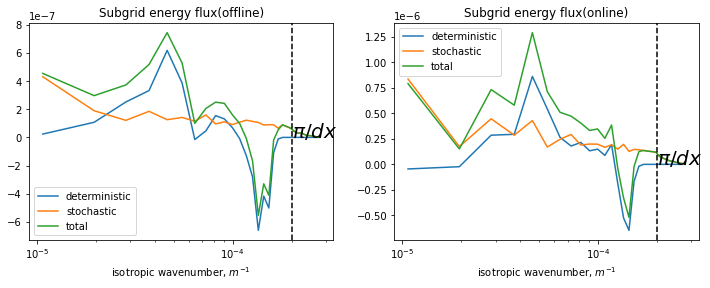

In [176]:
plotter()

# GZ model, Operator2

In [177]:
ds_offline, ds_online, sgs_offline, sgs_online = read_model_and_data('MeanVarModel', 'Operator2')

reading MeanVarModel from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/model


INFO:  Logger initialized
INFO:  Logger initialized


Noise to signal var: 0.13111895216279687
Signal var: 1.818916640171931e-23, noise var: 2.384944439308186e-24
Noise to signal var: 0.2108984961269248
Signal var: 8.24667754807424e-24, noise var: 1.7392118929325326e-24


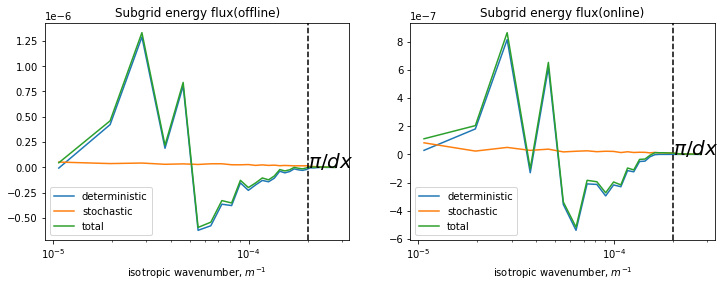

In [178]:
plotter()

# GAN Operator1

In [179]:
ds_offline, ds_online, sgs_offline, sgs_online = read_model_and_data('CGANRegression', 'Operator1')

reading CGANRegression from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/model


INFO:  Logger initialized
INFO:  Logger initialized


Noise to signal var: 0.1928004014645376
Signal var: 7.248651007103728e-23, noise var: 1.3975428242459236e-23
Noise to signal var: 0.18009666387054996
Signal var: 1.0558332712176587e-22, noise var: 1.901520497498299e-23


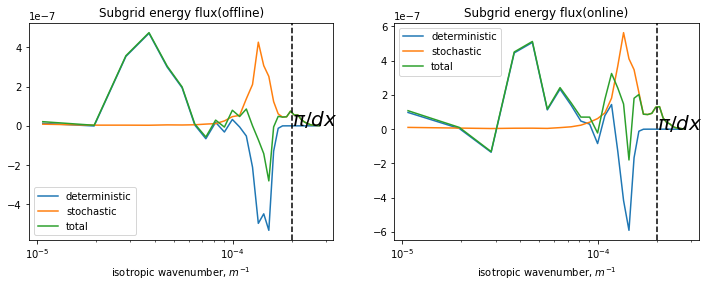

In [180]:
plotter()

# GAN Operator2

In [188]:
ds_offline, ds_online, sgs_offline, sgs_online = read_model_and_data('CGANRegression', 'Operator2')

reading CGANRegression from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/model


INFO:  Logger initialized
INFO:  Logger initialized


Noise to signal var: 0.22278915645092034
Signal var: 1.7754444320815147e-23, noise var: 3.95549767348924e-24
Noise to signal var: 0.40797497928885873
Signal var: 6.778840319606104e-24, noise var: 2.7655972389937806e-24


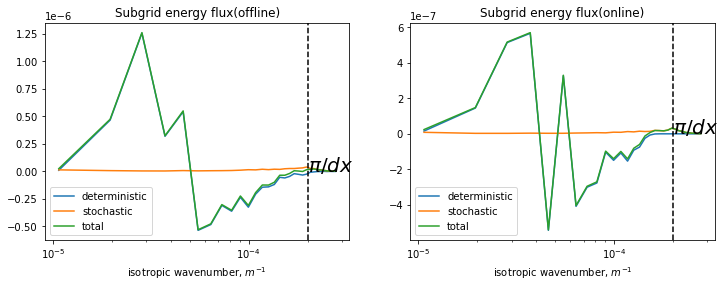

In [189]:
plotter()